In [1]:
#!pip install mlxtend
import pandas as pd
import numpy as np
# Import the association rules function
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
# Import the transaction encoder for identifying the unique items
from mlxtend.preprocessing import TransactionEncoder
# Import permutations for generating rules with itertools
from itertools import permutations
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
plt.style.use('ggplot')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/data/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [2]:
dataset = pd.read_csv('groceries.csv')

In [3]:
# Make a list of sublists from dataframe and claen all NaN values
data = [[val for val in sublist if val != ''] for sublist in dataset.drop(dataset.columns[0], axis=1).fillna('').values.tolist()]

<b>Preparing the data</b>

In [4]:
# Instantiate transaction encoder
encoder = TransactionEncoder().fit(data)
# One-hot encode itemsets by applying fit and transform
onehot = encoder.transform(data)
# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


<b>Computing support</b> 

In [5]:
# Computing top support for single items
onehot.mean().sort_values(ascending=False).head()

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
dtype: float64

<b>Pair 'Jam' + 'White bread'</b>

In [6]:
# Computing support for multiple items; define the itemset that contains white bread and jam
onehot['jam + white bread'] = np.logical_and(onehot['jam'],onehot['white bread'])
supportJB = onehot['jam + white bread'].mean()
supportJ = onehot['jam'].mean()
supportB = onehot['white bread'].mean()

<b>Computing confidence and lift </b>

In [7]:
# Compute and print confidence and lift for 'jam' and 'white bread'
confidenceJ = supportJB / supportJ
confidenceB = supportJ / supportB
lift = supportJB / (supportJ * supportB)
print(f"supportJ: {supportJ}\nconfidenceJ: {confidenceJ}\nconfidenceB: {confidenceB}\nlift: {lift}")

supportJ: 0.005388917132689374
confidenceJ: 0.05660377358490567
confidenceB: 0.12801932367149757
lift: 1.3446814328684717


<b>Computing leverage</b>

In [8]:
# Compute and print leverage
leverage = supportJB - supportJ * supportB
leverage

7.818894835450935e-05

<b>Computing conviction</b>

In [9]:
# Compute support for NOT 'white bread'
supportnB = 1.0 - onehot['white bread'].mean()
# Compute support for 'jam' and NOT 'white bread'
supportJnB = supportJ - supportJB
# Compute conviction
conviction = supportJ * supportnB / supportJnB
conviction

1.015379766141332

<b>Zhang's metric</b>

In [10]:
# +1 perfect association, -1 perferct dissociation
# Compute the numerator
num = supportJB - supportJ*supportB
# Compute the denominator
denom = max(supportJB*(1-supportJ), supportJ*(supportB-supportJB))
# Compute the Zhang's metric
zhang = num / denom
zhang

0.25771825802494397

<b>Find frequent itemsets</b>

In [11]:
# Extract unique items
flattened = [item for transaction in data for item in transaction]
items = list(set(flattened))
#Compute and print length of rules
rules = list(permutations(items, 2))
len(rules)

28392

In [12]:
# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.001, max_len = 2, use_colnames = True)
# Keep itemsets with only >= 2 items
itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
# Show the most frequent itemsets
itemsets.sort_values(by='support', ascending=False).head(5)

,support,itemsets
2684,0.074835,"(whole milk, other vegetables)"
2919,0.056634,"(whole milk, rolls/buns)"
3135,0.056024,"(whole milk, yogurt)"
2946,0.048907,"(whole milk, root vegetables)"
2651,0.047382,"(other vegetables, root vegetables)"


In [13]:
# Compute all association rules for frequent itemsets
rules = association_rules(frequent_itemsets, metric= "lift", min_threshold = 1.0)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Instant food products),(bottled water),0.008033,0.110524,0.001017,0.126582,1.145296,0.000129,1.018386,0.127891
1,(bottled water),(Instant food products),0.110524,0.008033,0.001017,0.009200,1.145296,0.000129,1.001178,0.142627
2,(butter),(Instant food products),0.055414,0.008033,0.001220,0.022018,2.741145,0.000775,1.014301,0.672452
3,(Instant food products),(butter),0.008033,0.055414,0.001220,0.151899,2.741145,0.000775,1.113765,0.640332
4,(Instant food products),(citrus fruit),0.008033,0.082766,0.001118,0.139241,1.682347,0.000454,1.065611,0.408877


<b>Heatmap visualization</b>

/home/data/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/data/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/data/.local/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/data/.local/lib/python3.10/site-packages/seaborn/matrix.py:316: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; pleas

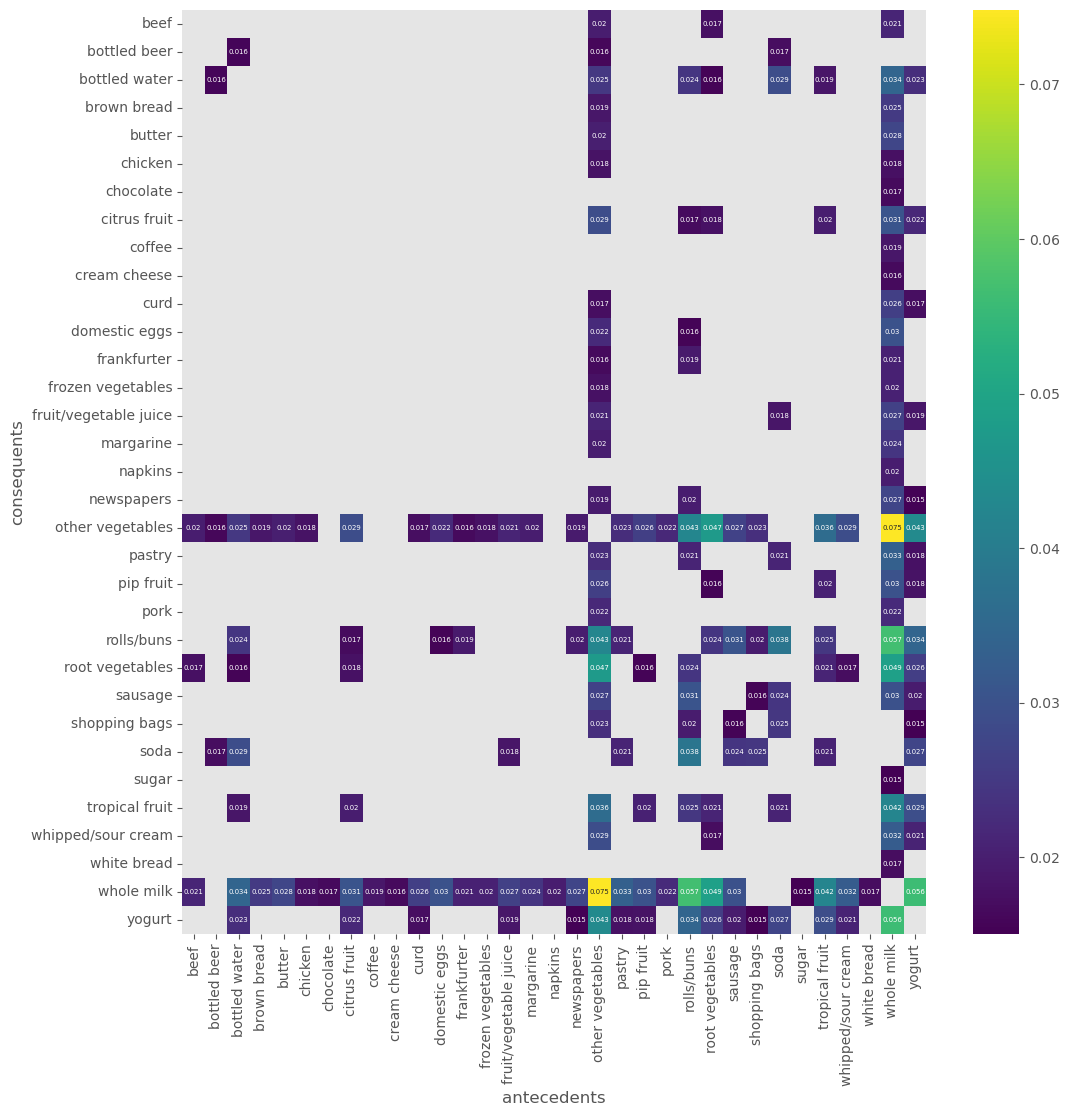

In [14]:
# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ''.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ''.join(list(a)))
# Set minimal support threshold equal to 0.015
rules = rules[rules['support']>0.015]
# Transform antecedent, consequent, and support columns into the matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='support')
# Generate heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(support_table, annot=True, cmap='viridis', annot_kws={"size":5})
plt.show()

<b>Scatterplot visualization</b>

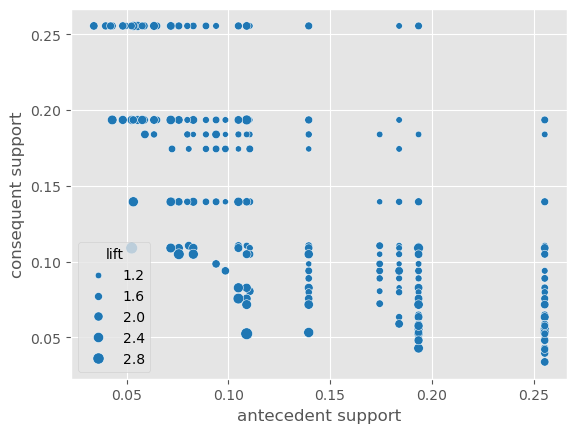

In [15]:
# Identify natural thresholds and data patterns to prune with scatterplot graphs
# find the point which no antecedent support no consequent support values exceed
sns.scatterplot(x='antecedent support', y='consequent support', size='lift', data=rules, color='#1f77b4')
plt.show()

~0.27, biggest dots are clustered around 0.10 values

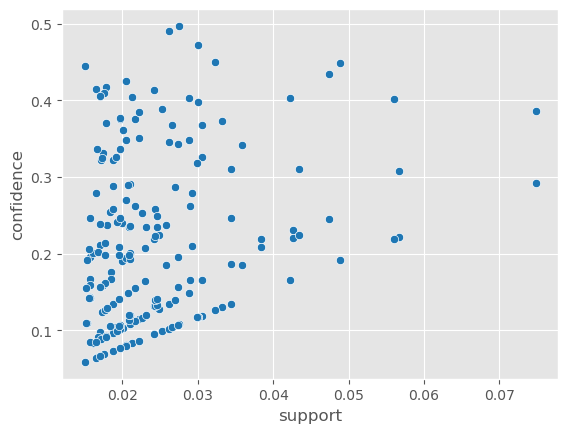

In [16]:
# since all optimal rules according to many common metrics are located on the confidence-support border, let's visualize them
sns.scatterplot(x='support', y='confidence', data=rules, color='#1f77b4')
plt.show()

<b>Parallel coordinates plot</b>

In [17]:
# We use such plotting if we want to know whether rule exists, examine final rules without visual clutter
# Convert rules to coordinates
rules['rule'] = rules.index
# Define coordinates and label
coords = rules[['antecedents', 'consequents', 'rule']]
coords.head()

,antecedents,consequents,rule
318,other vegetables,beef,318
319,beef,other vegetables,319
342,beef,root vegetables,342
343,root vegetables,beef,343
374,whole milk,beef,374


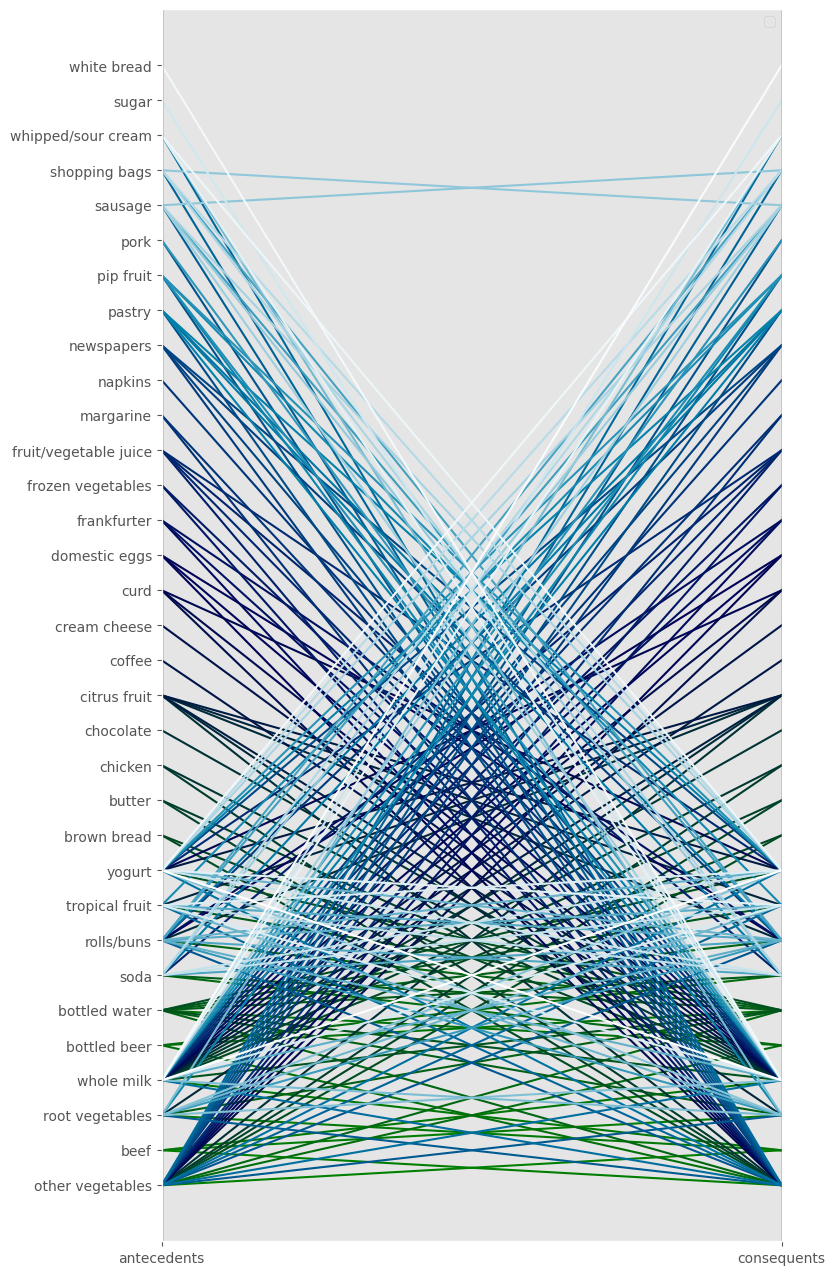

In [18]:
# Generate parallel coordinates plot
plt.figure(figsize=(8, 16))
parallel_coordinates(coords, 'rule', colormap='ocean')
plt.legend([])
plt.show()